<img src="https://i.stack.imgur.com/g1phN.png">

In [1]:
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew
import time

In [158]:
meta_features_names=["nr_instances", "log_nr_instances", "nr_features",\
    "log_nr_features", "nr_classes", "nr_numerical_features", "nr_categorical_features", \
    "ratio_num_cat", "class_entropy", "missing_val", "ratio_missing_val", "max_prob", \
    "min_prob", "mean_prob","std_dev", "dataset_ratio", "symbols_sum", "symbols_mean", \
    "symbols_std_dev", "skew_min", "skew_max", "skew_mean", "skew_std_dev", "kurtosis_min",\
    "kurtosis_max", "kurtosis_mean", "kurtosis_std_dev"]

def  extractMetaFeatures(dataset, classCol = None):
    t0 = time.time()
    
    #### 5. Number of Classes - DONE
    if classCol == None:
        target_variable_Index = dataset.shape[1] - 1
    else:
         target_variable_Index = dataset.columns.get_loc(classCol)
        
    target_variable = dataset.iloc[:, target_variable_Index]
    dataset.drop(dataset.columns[target_variable_Index], axis=1, inplace = True)
    nr_classes = target_variable.nunique()
    
    t1 = time.time()
    #print('1. Time spend:', t1 - t0)
    #### Remove Missing Values
    dataset.replace(to_replace = ["? ","?", " ?" "-" " -","- ", " - ", "#", " #", "# ", " "], value = np.NAN, inplace = True)
    dataset.dropna(axis = 1, how = 'all', inplace = True) # Drop Column if all of its values are missing

    #### Remove ID columns or columns with always the same value
    for col in dataset.columns:
        feature = dataset[col].dropna()
        numSyms = feature.nunique()
        if col == 'id' or col == 'ID' or numSyms == 1 or (numSyms == dataset.shape[0] and feature.dtype != np.number):
            dataset.drop(col, axis = 1, inplace = True)
    
    t0 = time.time()
    #print('Preprocessing Time spent:', t0 - t1)
    
    ### 1.Number of Instances - DONE
    nr_instances = dataset.shape[0]
    t1 = time.time()
    #print('1. Time spend:', t1 - t0)
    
    ### 2.Log number of Instances - DONE
    log_nr_instances = np.log(nr_instances)
    t2 = time.time()
    #print('2. Time spend:', t2 - t1)
    
    #### 3.Number of Features - DONE
    nr_features = dataset.shape[1]
    t3 = time.time()
    #print('3. Time spend:', t3 - t2)
    
    ### 4.Log Number of Features - DONE
    log_nr_features = np.log(nr_features)
    t4 = time.time()
    #print('4. Time spend:', t4 - t3)
    

    ### 6. Number of Missing Values
    ### 7. Ratio of Missing Values - DONE
    missing_val = 0
    missing_val = dataset.isnull().sum().sum() + dataset.isna().sum().sum()
    
    ratio_missing_val = missing_val / dataset.size
    t7 = time.time()
    #print('7. Time spend:', t7 - t6)
    
    ### 8. Number of Numerical Features - DONE
    ### 9. Number of Categorical Features - DONE
    numerical = []
    categorical = dataset.select_dtypes(exclude=['number']).columns.values.tolist()
    for col in dataset.columns:
        if col not in categorical:
            feature = dataset[col].dropna()
            numSyms = feature.nunique()
            if numSyms < log_nr_instances: #it should be considered as categorical if number of unique values < log number of instances
                categorical.append(col)
            else:
                numerical.append(col)
    
    nr_numerical_features = len(numerical)
    nr_categorical_features = len(categorical)
    
    t9 = time.time()
    #print('9. Time spend:', t9 - t7)
                
    ### 10. Ratio of Categorical to Numerical Features - DONE
    if(nr_numerical_features > 0):
        ratio_num_cat = nr_categorical_features / nr_numerical_features
    else:
        ratio_num_cat = 9999999999
    t10 = time.time()
    #print('10. Time spend:', t10 - t9)
    
    ### 11. Class Entropy - DONE
    prob_classes = []
    class_entropy = 0
    classes = target_variable.unique()
    
    for value in classes:
        prob = (sum(target_variable==value) / len(target_variable))
        
        prob_classes.append(prob)
        class_entropy = class_entropy - prob * np.log2(prob)
        
    ### 12. Maximum Class probability - DONE
    max_prob = max(prob_classes)
    
    ### 13. Minimum Class probability - DONE
    min_prob = min(prob_classes)
    
    ### 14. Mean Class probability - DONE
    mean_prob = np.mean(prob_classes)
    
    ### 15. Standard Deviation of Class probability - DONE
    std_dev = np.std(prob_classes)
    
    ### 16. Dataset Ratio - DONE
    dataset_ratio = nr_features / nr_instances
    
    t11 = time.time()
    #print('11. Time spend:', t11 - t10)
    
    ### Categorical Features Statistics
    symbols=[]
    if len(categorical) != 0:
        for col in categorical:
            feature = dataset[col].dropna()
            symbols.append(feature.nunique())
    
    ### 17. Symbols Sum - DONE
        symbols_sum = sum(symbols)
        
    ### 18. Symbols Mean - DONE
        symbols_mean = np.mean(symbols)

    ### 19. Symbols Standard Deviation - DONE
        symbols_std_dev = np.std(symbols)
        
    else:
        symbols_sum = 0
        symbols_mean = 0
        symbols_std_dev = 0
    
    t12 = time.time()
    #print('12. Time spend:', t12 - t11)
    
    ### Numerical Features Statistics
    skewness_values = np.zeros(len(numerical))
    kurtosis_values = np.zeros(len(numerical))
    
    #print(dataset)
    if len(numerical) != 0:
        for coli in range(len(numerical)):
            #print(numerical[coli])
            feature = dataset[numerical[coli]].dropna()
            #print('feat-AFTER:', feature)
            skewness = skew(feature)
            kurt = kurtosis(feature)
            skewness_values[coli] = skewness
            kurtosis_values[coli] = kurt
    
    ### 20. Skewness Minimum - DONE
        skew_min = min(skewness_values)

    ### 21. Skewness Maximum - DONE
        skew_max = max(skewness_values)

    ### 22. Skewness Mean - DONE
        skew_mean = np.mean(skewness_values)

    ### 23. Skewness Standard deviation - DONE
        skew_std_dev = np.std(skewness_values)

    ### 24. Kurtosis Minimum - DONE
        kurtosis_min = min(kurtosis_values)

    ### 25. Kurtosis Maximum - DONE
        kurtosis_max = max(kurtosis_values)

    ### 26. Kurtosis Mean - DONE
        kurtosis_mean = np.mean(kurtosis_values)

    ### 27. Kurtosis Standard Deviation - DONE
        kurtosis_std_dev = np.std(kurtosis_values)
    else:
        skew_min = 0
        skew_max = 0
        skew_mean = 0
        skew_std_dev = 0
        kurtosis_min = 0
        kurtosis_max = 0
        kurtosis_mean = 0
        kurtosis_std_dev = 0
    
    #t13 = time.time()
    #print('13. Time spend:', t13 - t12)    
    
    meta_features=np.array([nr_instances,log_nr_instances,nr_features,\
    log_nr_features,nr_classes,nr_numerical_features,nr_categorical_features,ratio_num_cat,\
    class_entropy, missing_val, ratio_missing_val,max_prob,min_prob, mean_prob,\
    std_dev,dataset_ratio,symbols_sum,symbols_mean,symbols_std_dev,\
    skew_min,skew_max,skew_mean,skew_std_dev,kurtosis_min,kurtosis_max,kurtosis_mean,kurtosis_std_dev])
    
    
    return  meta_features

In [161]:
meta_data=[]
path ='Datasets_all' 
allFiles = glob.glob(path + "/*.csv")
counter = 0
for file in allFiles:
    #counter += 1
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n', file)

    dataset = pd.read_csv(file, index_col=None, header=0)
    new_meta = extractMetaFeatures(dataset)
    
    print(new_meta)
    meta_data.append(new_meta)

meta_data=np.array(meta_data)

#print(meta_data)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\aaaData_for_UCI_named.csv
[ 1.00000000e+04  9.21034037e+00  1.30000000e+01  2.56494936e+00
  2.00000000e+00  1.30000000e+01  0.00000000e+00  0.00000000e+00
  9.44330826e-01  0.00000000e+00  0.00000000e+00  6.38000000e-01
  3.62000000e-01  5.00000000e-01  1.38000000e-01  1.30000000e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.26881061e-02
  1.86606422e-02  4.60199486e-04  6.24163780e-03 -1.20000444e+00
 -3.89873890e-01 -1.11551955e+00  2.23010627e-01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\AirlinesCodrnaAdult.csv
[ 1.07679000e+06  1.38894950e+01  2.90000000e+01  3.36729583e+00
  2.00000000e+00  1.30000000e+01  1.60000000e+01  1.23076923e+00
  9.89543661e-01  1.45500000e+04  4.65944277e-04  5.60125930e-01
  4.39874070e-01  5.00000000e-01  6.01259298e-02  2.69318994e-05
  7.30000000e+02  4.56250000e+01  9.39334039e+01 -6.30306796e+00
  7.73833485e+00  7.38575222e-01  3.00525991e+00 -1.66478216e+00
  8.69742952e+01  1.312518

[ 3.63000000e+02  5.89440283e+00  1.09350000e+04  9.29972393e+00
  2.00000000e+00  1.09350000e+04  0.00000000e+00  0.00000000e+00
  7.45517843e-01  0.00000000e+00  0.00000000e+00  7.87878788e-01
  2.12121212e-01  5.00000000e-01  2.87878788e-01  3.01239669e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.24249194e-01
  1.89618489e+01  2.75362822e+00  3.13237200e+00 -1.16292523e+00
  3.57702420e+02  2.26427073e+01  5.35026180e+01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\AP_Colon_Ovary.csv
[ 4.84000000e+02  6.18208491e+00  1.09350000e+04  9.29972393e+00
  2.00000000e+00  1.09350000e+04  0.00000000e+00  0.00000000e+00
  9.76020648e-01  0.00000000e+00  0.00000000e+00  5.90909091e-01
  4.09090909e-01  5.00000000e-01  9.09090909e-02  2.25929752e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.55494578e-01
  2.19208229e+01  3.23396321e+00  3.62023478e+00 -1.03799809e+00
  4.78681514e+02  3.11283629e+01  7.13665686e+01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\AP_Endo

[ 2.05000000e+02  5.32300998e+00  2.50000000e+01  3.21887582e+00
  2.00000000e+00  1.10000000e+01  1.40000000e+01  1.27272727e+00
  9.73732646e-01  1.14000000e+02  2.22439024e-02  5.95121951e-01
  4.04878049e-01  5.00000000e-01  9.51219512e-02  1.21951220e-01
  3.87000000e+02  2.76428571e+01  4.66102489e+01  6.26599168e-02
  2.79680143e+00  1.05091433e+00  9.18063717e-01 -6.89015401e-01
  1.33535077e+01  2.25474721e+00  4.01344038e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\autoMpg.csv
[ 3.98000000e+02  5.98645201e+00  7.00000000e+00  1.94591015e+00
  2.00000000e+00  4.00000000e+00  3.00000000e+00  7.50000000e-01
  9.98177694e-01  1.20000000e+01  4.30725054e-03  5.25125628e-01
  4.74874372e-01  5.00000000e-01  2.51256281e-02  1.75879397e-02
  1.01000000e+02  3.36666667e+01  4.19629466e+01  1.14910763e-02
  7.16930089e-01  3.83801291e-01  2.65490883e-01 -1.18148185e+00
  3.99207732e-01 -5.81323654e-01  5.90489743e-01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\autos.csv
[ 2.

[ 6.43000000e+03  8.76872982e+00  3.60000000e+01  3.58351894e+00
  6.00000000e+00  3.60000000e+01  0.00000000e+00  0.00000000e+00
  2.48336188e+00  0.00000000e+00  0.00000000e+00  2.38102644e-01
  9.72006221e-02  1.66666667e-01  6.19039769e-02  5.59875583e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.73854628e-01
  9.19280984e-01  4.04507946e-02  5.57737203e-01 -9.20046112e-01
  1.27605883e+00 -1.54930045e-01  8.33370658e-01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\dataset_187_abalone.csv
[ 4.17700000e+03  8.33734856e+00  8.00000000e+00  2.07944154e+00
  2.80000000e+01  7.00000000e+00  1.00000000e+00  1.42857143e-01
  3.60200715e+00  0.00000000e+00  0.00000000e+00  1.64950922e-01
  2.39406272e-04  3.57142857e-02  4.95749826e-02  1.91525018e-03
  3.00000000e+00  3.00000000e+00  0.00000000e+00 -6.39643462e-01
  3.12769368e+00  6.20145973e-01  1.15907326e+00 -4.68572578e-02
  7.59330987e+01  1.10185145e+01  2.65023660e+01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\da

[4.60100000e+03 8.43402895e+00 5.70000000e+01 4.04305127e+00
 2.00000000e+00 5.70000000e+01 0.00000000e+00 0.00000000e+00
 9.67360237e-01 0.00000000e+00 0.00000000e+00 6.05955227e-01
 3.94044773e-01 5.00000000e-01 1.05955227e-01 1.23886112e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.59115531e+00
 3.10519366e+01 1.11829917e+01 6.89504026e+00 5.25037901e+00
 1.47903219e+03 2.40906710e+02 2.94301543e+02]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\dataset_50_tic-tac-toe.csv
[9.58000000e+02 6.86484778e+00 9.00000000e+00 2.19722458e+00
 2.00000000e+00 0.00000000e+00 9.00000000e+00 1.00000000e+10
 9.30953986e-01 0.00000000e+00 0.00000000e+00 6.53444676e-01
 3.46555324e-01 5.00000000e-01 1.53444676e-01 9.39457203e-03
 2.70000000e+01 3.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\dataset_53_heart-statlog.csv
[ 2.70000000e+02  5.5984

[ 5.00000000e+02  6.21460810e+00  1.00000000e+01  2.30258509e+00
  2.00000000e+00  1.00000000e+01  0.00000000e+00  0.00000000e+00
  9.94406653e-01  0.00000000e+00  0.00000000e+00  5.44000000e-01
  4.56000000e-01  5.00000000e-01  4.40000000e-02  2.00000000e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.54886398e-01
  1.28133568e+00  1.58686528e-01  4.37661459e-01 -1.30311494e+00
  1.46948716e+00 -7.63686031e-01  8.24929098e-01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\GCM.csv
[ 1.90000000e+02  5.24702407e+00  1.60630000e+04  9.68427377e+00
  1.40000000e+01  1.60630000e+04  0.00000000e+00  0.00000000e+00
  3.69701034e+00  0.00000000e+00  0.00000000e+00  1.57894737e-01
  5.26315789e-02  7.14285714e-02  3.06062142e-02  8.45421053e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.34235362e+01
  1.35745682e+01  2.04483786e+00  2.56479744e+00 -1.65627784e+00
  1.83163647e+02  1.49413073e+01  2.23690475e+01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\gina_agnostic.csv


[ 2.00000000e+03  7.60090246e+00  6.00000000e+00  1.79175947e+00
  2.00000000e+00  3.00000000e+00  3.00000000e+00  1.00000000e+00
  4.68995594e-01  0.00000000e+00  0.00000000e+00  9.00000000e-01
  1.00000000e-01  5.00000000e-01  4.00000000e-01  3.00000000e-03
  1.60000000e+01  5.33333333e+00  1.69967317e+00  3.07076713e-01
  6.86867506e-01  5.44205649e-01  1.68825913e-01 -1.03876023e+00
 -6.26245273e-01 -7.70703400e-01  1.89736005e-01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\mfeat-pixel.csv
[2.00000000e+03 7.60090246e+00 2.40000000e+02 5.48063892e+00
 2.00000000e+00 0.00000000e+00 2.40000000e+02 1.00000000e+10
 4.68995594e-01 0.00000000e+00 0.00000000e+00 9.00000000e-01
 1.00000000e-01 5.00000000e-01 4.00000000e-01 1.20000000e-01
 1.64800000e+03 6.86666667e+00 4.90464632e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\mnist_784.csv
[ 7.00000000e+04  1.115

[ 1.00000000e+03  6.90775528e+00  2.10000000e+01  3.04452244e+00
  3.00000000e+01  2.00000000e+01  1.00000000e+00  5.00000000e-02
  4.64856208e+00  0.00000000e+00  0.00000000e+00  8.00000000e-02
  6.00000000e-03  3.33333333e-02  2.05220748e-02  2.10000000e-02
  2.00000000e+00  2.00000000e+00  0.00000000e+00 -7.92366392e-02
  3.98178218e+00  1.13824975e+00  9.78142834e-01 -6.45206252e-01
  2.75173061e+01  3.58187859e+00  6.51040423e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\php5s7Ep8.csv
[ 1.94100000e+03  7.57095858e+00  2.70000000e+01  3.29583687e+00
  7.00000000e+00  2.40000000e+01  3.00000000e+00  1.25000000e-01
  2.41069044e+00  0.00000000e+00  0.00000000e+00  3.46728490e-01
  2.83359093e-02  1.42857143e-01  1.06384838e-01  1.39103555e-02
  7.00000000e+00  2.33333333e+00  4.71404521e-01 -9.27864652e-01
  3.92627862e+01  4.21840771e+00  8.87303464e+00 -1.70638789e+00
  1.65876784e+03  1.23193610e+02  3.56922823e+02]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\php7KLval.cs

[6.40000000e+01 4.15888308e+00 3.72100000e+03 8.22174773e+00
 2.00000000e+00 0.00000000e+00 3.72100000e+03 1.00000000e+10
 9.93650712e-01 0.00000000e+00 0.00000000e+00 5.46875000e-01
 4.53125000e-01 5.00000000e-01 4.68750000e-02 5.81406250e+01
 7.44200000e+03 2.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\phpfKh1CO.csv
[4.40000000e+02 6.08677473e+00 8.00000000e+00 2.07944154e+00
 3.00000000e+00 6.00000000e+00 2.00000000e+00 3.33333333e-01
 1.12771663e+00 0.00000000e+00 0.00000000e+00 7.18181818e-01
 1.06818182e-01 3.33333333e-01 2.73548847e-01 1.81818182e-02
 5.00000000e+00 2.50000000e+00 5.00000000e-01 2.55258269e+00
 1.11135336e+01 5.13141816e+00 2.85503922e+00 1.13921239e+01
 1.68747781e+02 4.96695192e+01 5.49230061e+01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\phpflaNJC.csv
[ 3.40000000e+02  5.82894562e+00  1.50000000e+01  2.

[1.08000000e+03 6.98471632e+00 8.56000000e+02 6.75227038e+00
 9.00000000e+00 0.00000000e+00 8.56000000e+02 1.00000000e+10
 3.16992500e+00 0.00000000e+00 0.00000000e+00 1.11111111e-01
 1.11111111e-01 1.11111111e-01 0.00000000e+00 7.92592593e-01
 1.82300000e+03 2.12967290e+00 3.84583627e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\phpmPOD5A.csv
[ 3.27690000e+04  1.03972382e+01  9.00000000e+00  2.19722458e+00
  2.00000000e+00  9.00000000e+00  0.00000000e+00  0.00000000e+00
  3.19011748e-01  0.00000000e+00  0.00000000e+00  9.42109921e-01
  5.78900790e-02  5.00000000e-01  4.42109921e-01  2.74649821e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.40451911e+01
  1.33567037e+01  5.22702430e-01  7.14635075e+00 -1.48257859e+00
  3.85424524e+02  9.19527836e+01  1.28537014e+02]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\phpn1jVwe.csv
[ 1.11830000e+04  9.32215

[ 9.45000000e+02  6.85118493e+00  6.34900000e+03  8.75605260e+00
  7.00000000e+00  6.34200000e+03  7.00000000e+00  1.10375276e-03
  2.80524255e+00  0.00000000e+00  0.00000000e+00  1.48148148e-01
  1.25925926e-01  1.42857143e-01  7.63079635e-03  6.71851852e+00
  2.90000000e+01  4.14285714e+00  9.89743319e-01 -3.04553140e+01
  3.06341286e+01  1.20568846e+00  3.14587662e+00 -1.89321235e+00
  9.37590565e+02  1.71676636e+01  6.53810375e+01]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\phpvcoG8S.csv
[ 5.39383000e+05  1.31981812e+01  7.00000000e+00  1.94591015e+00
  2.00000000e+00  3.00000000e+00  4.00000000e+00  1.33333333e+00
  9.91394387e-01  0.00000000e+00  0.00000000e+00  5.54557708e-01
  4.45442292e-01  5.00000000e-01  5.45577076e-02  1.29777913e-05
  6.11000000e+02  1.52750000e+02  1.40303911e+02  7.63843975e-02
  1.49390037e+00  8.13059094e-01  5.80043626e-01 -1.01453444e+00
  2.75659391e+00  4.61782337e-01  1.64474974e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\phpVDlhKL.cs

[ 5.80000000e+04  1.09681983e+01  9.00000000e+00  2.19722458e+00
  7.00000000e+00  9.00000000e+00  0.00000000e+00  0.00000000e+00
  9.60301361e-01  0.00000000e+00  0.00000000e+00  7.85965517e-01
  1.72413793e-04  1.42857143e-01  2.67696314e-01  1.55172414e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.18612450e+01
  3.16870338e+01  2.36880266e+00  1.28518975e+01  5.43447021e-01
  7.69756112e+03  1.81749343e+03  2.83382970e+03]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\solar-flare_1.csv
[ 3.15000000e+02  5.75257264e+00  1.20000000e+01  2.48490665e+00
  5.00000000e+00  1.00000000e+00  1.10000000e+01  1.10000000e+01
  2.20898911e+00  0.00000000e+00  0.00000000e+00  2.79365079e-01
  6.66666667e-02  2.00000000e-01  7.19171999e-02  3.80952381e-02
  2.80000000e+01  2.54545455e+00  7.82029570e-01 -5.65961263e-01
 -5.65961263e-01 -5.65961263e-01  0.00000000e+00 -1.02237040e+00
 -1.02237040e+00 -1.02237040e+00  0.00000000e+00]
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all\syntheti

In [162]:
copyMeta = meta_data.copy()

##### Function to remove outliers

In [163]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

#### Histogram Plotting

Meta-Data Shape: (201, 27)
Length of Meta Features Names: 27


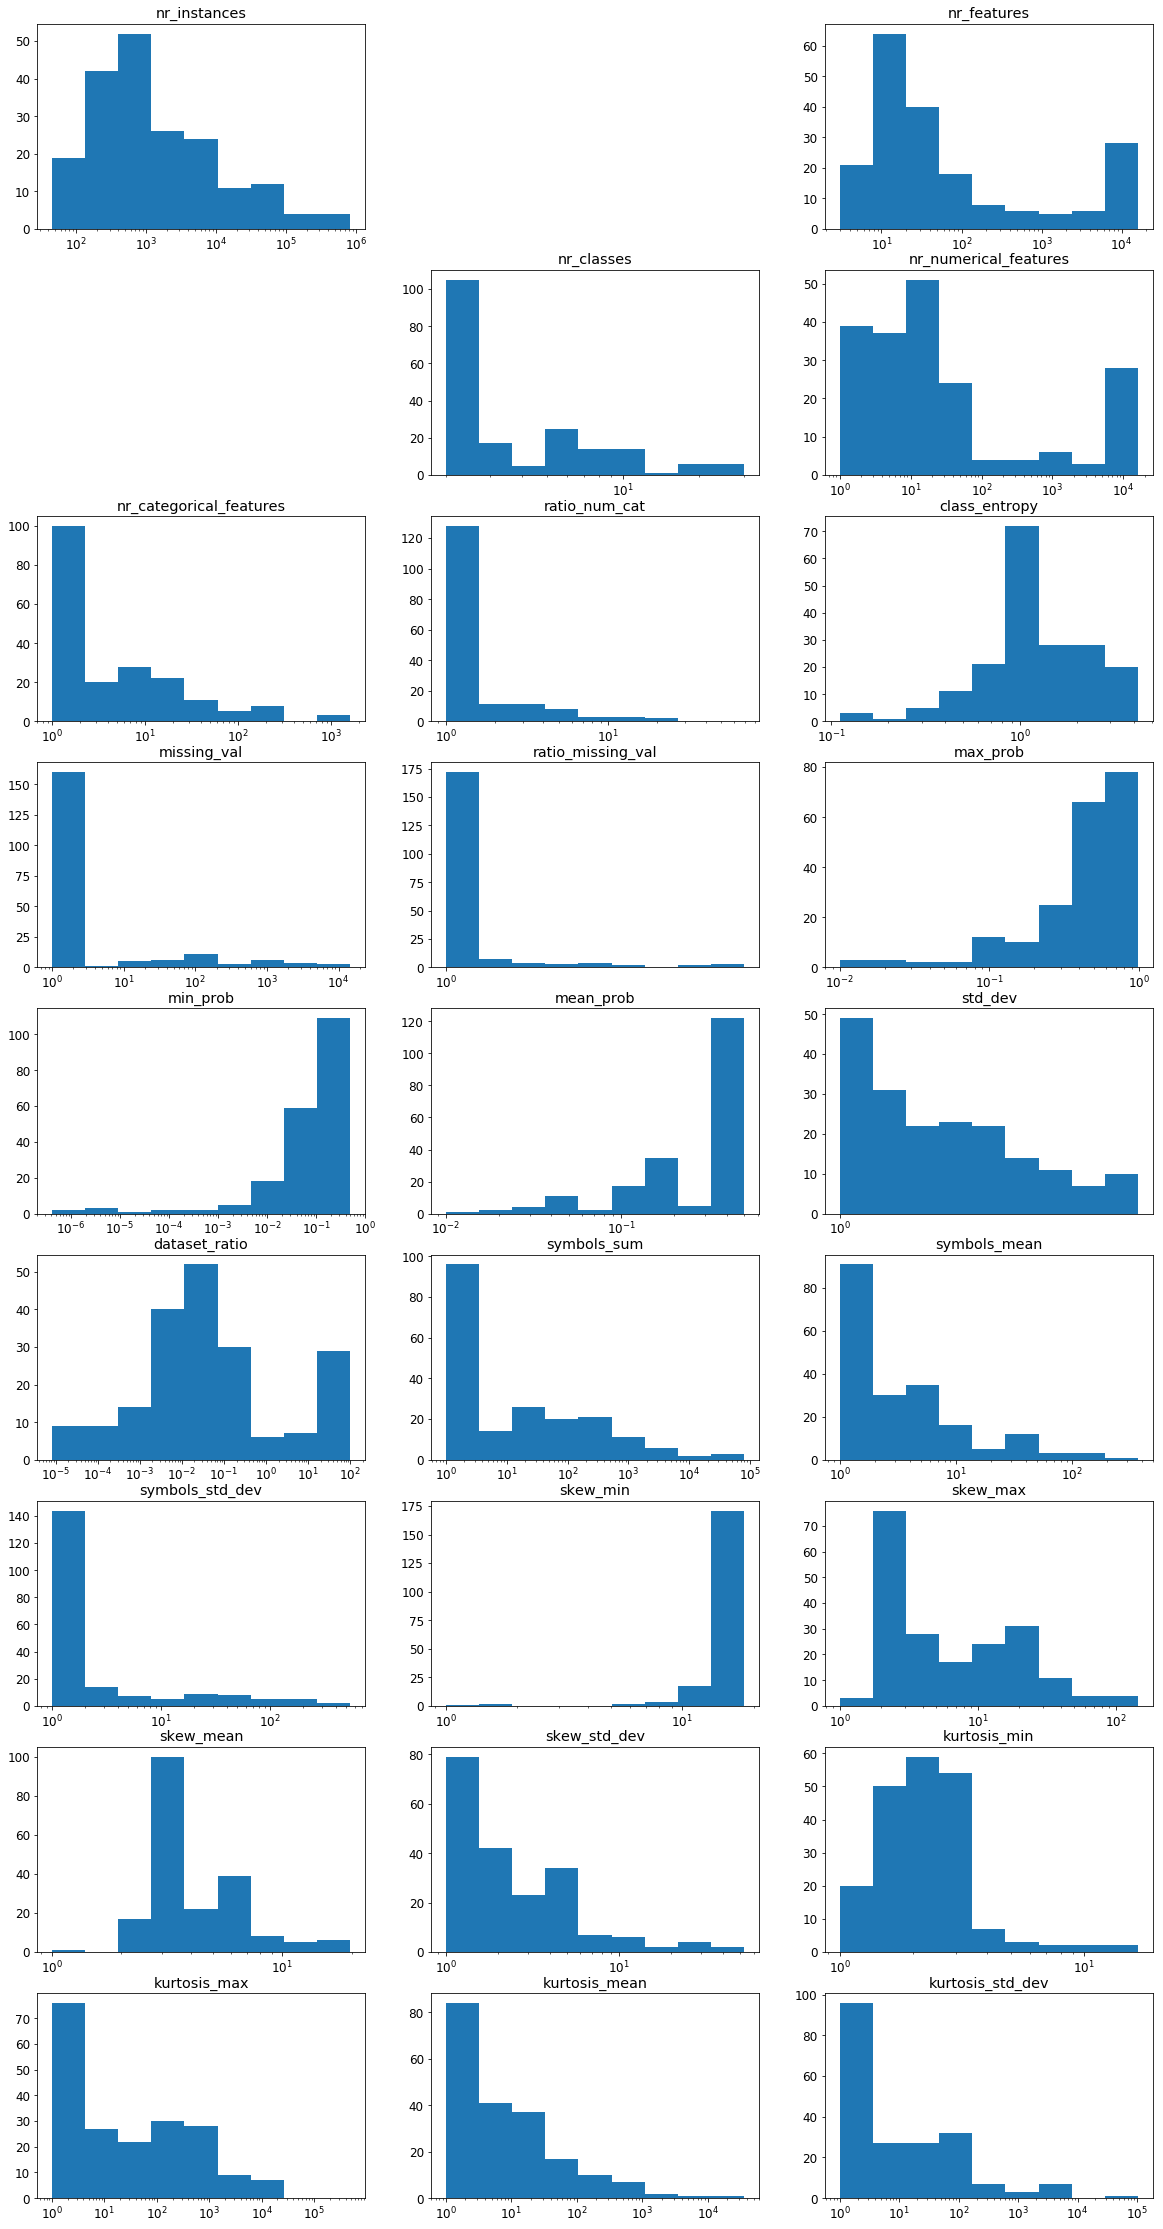

In [165]:
meta_data = copyMeta.copy()
def histogram(meta_data,meta_features_names):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['figure.figsize'] = (20, 40)
    j=0
    print("Meta-Data Shape:", meta_data.shape)
    print("Length of Meta Features Names:", len(meta_features_names))
    for i in meta_data.T:
        text = meta_features_names[j]
        if j == 1 or j == 3:
            j += 1
            continue
            
        ax = plt.subplot(9,3,1+j)
        plt.xscale("log")

        plt.title('{}'.format(text))
        
        i = reject_outliers(i, 2)
        mini = min(i)
        maxi = max(i)    
        
        if mini <=  0:
            i -= (mini-1)
        
        #print('feature processing now: ', text, ' --- mini:', mini, ' --- maxi:', maxi, '===i===', j)
        plt.hist(i, bins = np.logspace(np.log10(min(i)), np.log10(max(i)), 10))

        j=j+1
    plt.savefig("All-Datasets.png")
    plt.show()
histogram(meta_data,meta_features_names)

#### Heat Map Plotting

In [ ]:
plt.rcParams['figure.figsize'] = (100, 40)
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
im = ax.imshow(meta_data.T)

dataset_info=np.arange(1, 20, 1, dtype=int)

# We want to show all ticks...
ax.set_xticks(np.arange(len(dataset_info)))
ax.set_yticks(np.arange(len(meta_features_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(dataset_info)
ax.set_yticklabels(meta_features_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(meta_features_names)):
    for j in range(len(dataset_info)):
        text = ax.text(j, i, int(meta_data[j, i]), ha="center", va="center", color="w")

ax.set_title("")
#fig.tight_layout()
plt.savefig("heatmap.png")
plt.show()